# Cross Fold Validation Neural Network
By Brandon Khuu
Last updated: 5/4/2021

### Goal
The goal of this model is to create a neural network that would be able to classify whether a patient did or did not have Autism based on mRNA data(FPKM reads).  

The data was from Elaine Lim Lab.

In [1]:
#import libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

## Import Data

Data that is import was cleaned and preprocess in the data_preprocessing.py<br>
The data was raw fpkm mRNA reads that were cleaned by applying a threshold and outliers were removed.

The threshold applied was if the FPKM read has a mean of at least 2. Any read that was below 2 was filterd out.

After a threshold was applied, outliers were removed by creating a mathmatical filter.  Any reads that were above the function IQR*1.5 were assumed to be an outlier and removed.

In [2]:
#import data
df = pd.read_csv('Organoid Files/all_autism_fpkm_iqr_1.5_outliers.csv', header=0, index_col=0)
df.head()

,Autism,CDK5RAP1,TMEM246,PKD1,EDEM1,LSM11,COL26A1,CPSF6,DCTN5,TIMM9,...,NHLRC3,CCDC130,PIK3C3,PRKAB2,EIF2B3,C15orf61,IPP,ASB3,EHD4,NRSN2
PGP1-1,0.0,5.561823,9.167399,4.762467,4.259699,3.333153,5.245319,15.288924,10.670947,12.501312,...,3.577807,10.246243,9.379072,7.974797,6.506580,1.808342,2.624415,5.473228,9.892221,14.017985
PGP1-2,0.0,2.050032,6.121957,3.086031,3.888580,3.064389,4.530108,14.225061,11.109630,14.227982,...,2.951153,8.455335,13.197261,7.847511,6.687741,1.614225,3.276070,7.483068,7.377414,11.613564
PGP1-3,0.0,2.481599,14.205795,8.663784,2.988719,13.747564,6.189141,18.021990,15.850792,9.134396,...,3.211442,9.928194,7.313368,9.023667,6.744241,3.626686,2.221963,5.087976,2.392554,15.666102
GM23716-1,0.0,4.396121,15.263531,8.198981,3.433083,13.873706,5.018456,17.714552,15.832140,8.492397,...,3.052629,9.895930,7.927309,9.817574,6.570986,3.988325,2.459700,4.626596,2.301205,16.500382
GM23716-2,0.0,3.721746,14.125613,10.278191,3.331196,13.211928,5.620373,15.806883,15.434513,8.410669,...,2.743381,9.354041,8.525394,8.338526,5.990253,3.849378,2.494851,4.843815,2.285043,18.534124


## Split data

Data is split by target(y) and features(x)

In [3]:
#split x and y base
y = df.Autism
x = df.iloc[:,1:]

## Create Model

Import keras from tensor flow to create a neural network model to be trained.<br>
Model<br>
   -1 input layer<br>
   -1 batch normalization<br>
   -1 dropout at .2<br>
   -output layer<br>
Compiled <br>
    -optimizer: RMSprop algorithm which maintains a moving discounted average of the square of the gradients and divides the graident by the root of the average.<br>
    -loss function: binary cross entropty<br>
    -metric: accuracy<br>

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

#create early stop
early_stop = keras.callbacks.EarlyStopping(monitor='loss',patience=2, verbose=1)

#create model
model = keras.Sequential([
    layers.Dense(units=100, activation='relu',input_shape=[8163]),
    #layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units=1,activation='sigmoid')
])

#compile model with functions
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Train Model

Fit the model with the training data using cross fold validation(kfold). <br>
Split data into train and test data using KFold function .split<br>

In [5]:
#import cross fold validation
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

k = 5 #number of folds

#initialize kfold
kf = KFold(n_splits=k, random_state=0, shuffle=True)

#create empty list to hold scores
acc_score = []

#split training data
for train_index,test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index,:], x.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    #fit model with training data
    history = model.fit(x_train, y_train, validation_data=(x_test,y_test),
                        batch_size = 25, epochs=100, shuffle=True, callbacks=[early_stop])
    pred = model.predict(x_test)
    
    #record accuracy of each fold
    acc = accuracy_score(pred.round(), y_test)
    acc_score.append(acc)

Epoch 1/100
3/3 [==============================] - 1s 100ms/step - loss: 30.5881 - accuracy: 0.5279 - val_loss: 1.6370 - val_accuracy: 0.6667
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 11.5776 - accuracy: 0.5668 - val_loss: 24.4313 - val_accuracy: 0.4000
Epoch 3/100
3/3 [==============================] - 0s 13ms/step - loss: 23.5376 - accuracy: 0.5529 - val_loss: 9.1825 - val_accuracy: 0.4000
Epoch 4/100
3/3 [==============================] - 0s 15ms/step - loss: 14.2352 - accuracy: 0.4611 - val_loss: 8.6610 - val_accuracy: 0.6000
Epoch 00004: early stopping
Epoch 1/100
3/3 [==============================] - 0s 37ms/step - loss: 10.8945 - accuracy: 0.5789 - val_loss: 1.2966 - val_accuracy: 0.9286
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 9.4456 - accuracy: 0.5965 - val_loss: 1.5143 - val_accuracy: 0.8571
Epoch 3/100
3/3 [==============================] - 0s 12ms/step - loss: 5.4650 - accuracy: 0.6842 - val_loss: 4.6233 - val_ac

In [6]:
#Print accuracy of the model
avg_score = sum(acc_score)/k
print('Accuracy of each fold = {}'.format(acc_score))
print('Avg accuracy = {}'.format(avg_score))

Accuracy of each fold = [0.6, 1.0, 0.9285714285714286, 0.9285714285714286, 1.0]
Avg accuracy = 0.8914285714285715


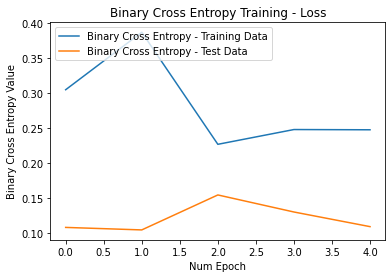

In [7]:
plt.plot(history.history['loss'], label='Binary Cross Entropy - Training Data')
plt.plot(history.history['val_loss'], label='Binary Cross Entropy - Test Data')
plt.title('Binary Cross Entropy Training - Loss')
plt.ylabel('Binary Cross Entropy Value')
plt.xlabel('Num Epoch')
plt.legend(loc='upper left')
plt.show()

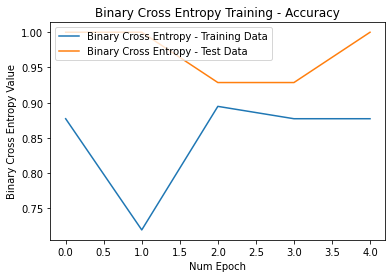

In [8]:
plt.plot(history.history['accuracy'], label='Binary Cross Entropy - Training Data')
plt.plot(history.history['val_accuracy'], label='Binary Cross Entropy - Test Data')
plt.title('Binary Cross Entropy Training - Accuracy')
plt.ylabel('Binary Cross Entropy Value')
plt.xlabel('Num Epoch')
plt.legend(loc='upper left')
plt.show()